In [2]:
from utils import *
import numpy as np

# Data preprocessing : 

## Goal: Preprocess the dataset
- Handle nan values
- Type conversion
- Transform numerical values

## Main points from [data exploration](1.exploration.ipynb)

**Datasets nomenclature**
- BeerAdvocate : BA or ba
- RateBeer : RB or rb
- Matched_beer_data : MBD or matched

**Rating ranges and formulas**
- The score appearance, aroma, palate, taste, overall **ranges** and **resolution** in ba and rb :
    - BA 
        + ranges (resp.) : 1-5,1-5,1-5,1-5,1-5  
        + with 0.25 resolution
    - RB 
        + ranges (resp.) : 1-5,1-10,1-5,1-10,1-20 
        + with 1 resolution
- the **rating is a linear combination** of the 5 mentioned score above
    - BA rating 
        + rating = 0.06 * appearance + 0.24 * aroma + 0.10 * palate + 0.40 * taste + 0.20 * overall 
        + range from 1 to 5
    - RB rating 
        + rating = 0.1 * appearance + 0.1 * aroma + 0.1 * palate + 0.1 * taste + 0.1 * overall
        + range from 1 to 5

    + Therefore the ratings from both datasets are not comparable

**Aggragated scores from all users** 

+ BOTH : **z-score is only computed** for data occuring **in MBD**
    - The z-score of a beer, is the z-score of with all the ratings of the same beer occuring the **same year**
+ BOTH : avg_computed may differ from avg, since ba and rb drops some ratings on some criterion


+ BA : bros_score in the BA dataset is a score given by the founders of BA 
+ BA : ba_score is the score of the beer by the BA community, see description [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)


+ RB : style score is a ranking of the beer among the beer of the same style. High rank (e.g 80 is better than 3 for beer of the same style)

+ RB : overall score is in range (1-100) and is a score to rank all the beers on RB
    - RateBeer uses an algorithm when calculating the overall score, considering both the ratings given by each user and the total number of ratings for the beer. Need at least 10 ratings

## Load data

**Dataset prefiltering**
- reviews are just the ratings that contain a text review. To avoid duplicates let's not load it
- MBD do not give us the information we need. Let's not load it
    + We won't use the already computed z-score, since it's limited to this dataset

**RAM limitation :**

In [3]:
REDUCED = None
#REDUCED = 2e6  # 1e6 <=> Approx 25% of the ratings (approx : 3Gb), set to None to load all the data

**Loading**

In [4]:
%%time
beers_ba, breweries_ba, users_ba, ratings_ba = load_data('ba', REDUCED)
beers_rb, breweries_rb, users_rb, ratings_rb = load_data('rb', REDUCED)

CPU times: user 40.5 s, sys: 2.52 s, total: 43 s
Wall time: 43 s


## Filtering out useless information/Nan

In [5]:
# Drop information about MBD
beers_ba = beers_ba.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)
beers_rb = beers_rb.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)

# Drop beers without more than 'min_ratings' ratings
n_beers_ba = len(beers_ba) 
n_beers_rb = len(beers_rb)

min_ratings = 0 
print(f'Filtering out all beers with {min_ratings} ratings or less')
beers_ba = beers_ba[beers_ba.nbr_ratings>min_ratings]
beers_rb = beers_rb[beers_rb.nbr_ratings>min_ratings]

# Drop beers with important information missing
beers_ba = beers_ba.dropna(subset=['abv'])
beers_rb = beers_rb.dropna(subset=['abv'])

print(f'Beers kept : ')
print(f'\t BA : {len(beers_ba)}/{n_beers_ba}')
print(f'\t RB : {len(beers_rb)}/{n_beers_rb}')

# Filter out breweries with only beers that have been filtered out
n_breweries_ba = len(breweries_ba) 
n_breweries_rb = len(breweries_rb) 
breweries_ba = breweries_ba[breweries_ba['id'].isin(beers_ba['brewery_id'])]
breweries_rb = breweries_rb[breweries_rb['id'].isin(beers_rb['brewery_id'])]
print(f'Breweries kept : ')
print(f'\t BA : {len(breweries_ba)}/{n_breweries_ba}')
print(f'\t RB : {len(breweries_rb)}/{n_breweries_rb}')

# Filter out ratings about beers that have been filtered out
n_ratings_ba = len(ratings_ba)
n_ratings_rb = len(ratings_rb)
ratings_ba = ratings_ba[ratings_ba['beer_id'].isin(beers_ba['beer_id'])]
ratings_rb = ratings_rb[ratings_rb['beer_id'].isin(beers_rb['beer_id'])]
print(f'Ratings kept : ')
print(f'\t BA : {len(ratings_ba)}/{n_ratings_ba}')
print(f'\t RB : {len(ratings_rb)}/{n_ratings_rb}')

Filtering out all beers with 0 ratings or less
Beers kept : 
	 BA : 217107/280823
	 RB : 359958/442081
Breweries kept : 
	 BA : 12934/16758
	 RB : 20804/24189
Ratings kept : 
	 BA : 8221727/8393032
	 RB : 6947090/7122074


**Questions**  : 
- Should we keep the aggregated score ? ba_score, bros_score, overall_score, style_score, avg, avg_computed ?
- Should we increase the minimum number of ratings above 0 ?

## Populate ratings with location of beer and user

In [6]:
# Rename location variable in users and breweries
users_ba.rename(columns={'location':'user_location'}, inplace=True)
breweries_ba.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)
users_rb.rename(columns={'location':'user_location'}, inplace=True)
breweries_rb.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)

# Populate ratings with locations from users and breweries
ratings_ba = pd.merge(left=ratings_ba, right=users_ba[['user_id', 'user_location']], on='user_id', how='left')
ratings_ba = pd.merge(left=ratings_ba, right=breweries_ba[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=users_rb[['user_id', 'user_location']], on='user_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=breweries_rb[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')

**Questions**
- Should we ensure that each location has only one name so that the location are comparable ?
- Should we keep the intermediate scores : appearance, aroma, taste, palate, overall ? Or only keep rating ?

## Transform ratings to normal distribution and compute zscore

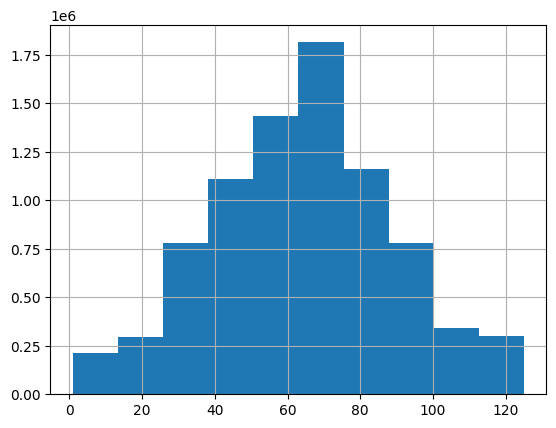

In [7]:
ratings_ba.rating.apply(lambda x: x**3).hist()
ratings_ba['zscore'] = ratings_ba['rating'].apply(lambda x: x**3)
ratings_ba['zscore'] = (ratings_ba['zscore']-ratings_ba['zscore'].mean())/ratings_ba['zscore'].std()

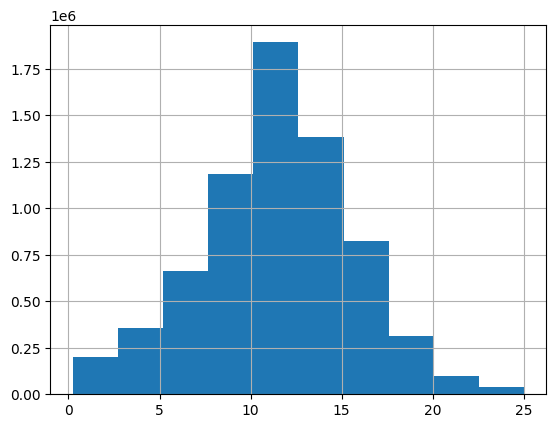

In [8]:
ratings_rb.rating.apply(lambda x: x**2).hist()
ratings_rb['zscore'] = ratings_rb['rating'].apply(lambda x: x**2)
ratings_rb['zscore'] = (ratings_rb['zscore']-ratings_rb['zscore'].mean())/ratings_rb['zscore'].std()

**Questions**
- Should we try without transformation ?
- Should we already make the dummy variables for the countries ? Or only work with a variable saying if the location is the same for the user and the brewery ?

## Save transformed ratings

In [12]:
ratings_ba.sample(frac=0.1, random_state=42).to_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
ratings_rb.sample(frac=0.1, random_state=42).to_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')